In [1]:
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
current_path = os.path.abspath('.')
label_encoder = LabelEncoder()
fi=os.path.abspath('../../data/cohorted_data.csv')
data = pd.read_csv(fi)
data.fillna(0, inplace=True)

In [2]:
data['admElective'] = label_encoder.fit_transform(data['admElective'])
data['hadMeasurmentDayOne'] = label_encoder.fit_transform(data['hadMeasurmentDayOne'])

# Create nice column names
niceColumns=['isMale','english_Proficent','copd_present','diabetes',
             'asthma_present','admElective','hadSteroid','major_surgery'] 

# Categorical variables
categorical_vars = ['insurance','anchor_year_group','race_group']
dummy_vars = pd.get_dummies(data[categorical_vars])
dummy_vars = dummy_vars.drop(columns=['race_group_White'])
dummy_vars = dummy_vars.drop(columns=['anchor_year_group_2008 - 2010'])
dummy_vars = dummy_vars.drop(columns=['insurance_Other'])

catevar=['insurance_Medicaid','insurance_Medicare','anchor_year_group_2011 - 2013',
         'anchor_year_group_2014 - 2016','anchor_year_group_2017 - 2019',
         'race_group_Asian','race_group_Black','race_group_Hispanic'
         ]

# Continuous variables
data = pd.concat([data, dummy_vars], axis=1)
continuous_vars = ['age','charlson_comorbidity_index','SOFA']

In [3]:
# Combine variables and define dependent variable
varsCombined=continuous_vars+niceColumns+catevar
independent = data[varsCombined]
dependent = data['hadMeasurmentDayOne']
independent[catevar] = independent[catevar].astype(int)

/var/folders/78/7bh523553yl6dn_r17wfrql40000gn/T/ipykernel_7001/384726723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  independent[catevar] = independent[catevar].astype(int)


In [4]:
import statsmodels.api as sm

# Fit logistic regression model
independent = sm.add_constant(independent)
model = sm.Logit(dependent, independent)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.288076
         Iterations 7


In [15]:
import numpy as np

# Get the coefficient values from the result
coefficients = result.params

# Exponentiate the coefficients to get the odds ratios
odds_ratios = np.exp(coefficients)

# Get the confidence intervals for the coefficients
confidence_intervals = result.conf_int()

# Exponentiate the confidence intervals to get the odds ratio confidence intervals
odds_ratio_lower = np.exp(confidence_intervals[0])
odds_ratio_upper = np.exp(confidence_intervals[1])

# Combine odds ratios and confidence intervals into a DataFrame for better readability
varNames=independent.columns
ratioCI = pd.DataFrame({'Variable':varNames,'Odds Ratio': odds_ratios, 'CI_lower': odds_ratio_lower, 'CI_upper': odds_ratio_upper})

# Display the odds ratios and their confidence intervals
ratioCI

,Variable,Odds Ratio,CI_lower,CI_upper
const,const,5.628294,4.138967,7.653527
age,age,0.995378,0.991735,0.999035
charlson_comorbidity_index,charlson_comorbidity_index,1.052719,1.032085,1.073765
SOFA,SOFA,1.087515,1.071202,1.104077
isMale,isMale,0.932556,0.851372,1.021481
english_Proficent,english_Proficent,0.975826,0.819918,1.161379
copd_present,copd_present,0.998281,0.835558,1.192693
diabetes,diabetes,1.699863,1.420728,2.033840
asthma_present,asthma_present,1.384064,0.551759,3.471867
admElective,admElective,0.822296,0.650181,1.039971


In [16]:
# Rename variables to be easily readable for publication
ratioCI['Variable'] = ratioCI['Variable'].replace('insurance_Medicaid', 'Medicaid')
ratioCI['Variable'] = ratioCI['Variable'].replace('insurance_Medicare', 'Medicare')
ratioCI['Variable'] = ratioCI['Variable'].replace('charlson_comorbidity_index', 'Charlson comorbidity index')
ratioCI['Variable'] = ratioCI['Variable'].replace('race_group_Asian', 'Asian')
ratioCI['Variable'] = ratioCI['Variable'].replace('race_group_Black', 'Black')
ratioCI['Variable'] = ratioCI['Variable'].replace('race_group_Hispanic', 'Hispanic')
ratioCI['Variable'] = ratioCI['Variable'].replace('major_surgery', 'Major Surgery')
ratioCI['Variable'] = ratioCI['Variable'].replace('anchor_year_group_2017 - 2019', '2017-2019')
ratioCI['Variable'] = ratioCI['Variable'].replace('anchor_year_group_2014 - 2016', '2014-2016')
ratioCI['Variable'] = ratioCI['Variable'].replace('anchor_year_group_2011 - 2013', '2011-2013')
ratioCI['Variable'] = ratioCI['Variable'].replace('english_Proficent', 'English proficient')
ratioCI['Variable'] = ratioCI['Variable'].replace('age', 'Age')
ratioCI['Variable'] = ratioCI['Variable'].replace('hadSteroid', 'Glucocorticoid on day 1')
ratioCI['Variable'] = ratioCI['Variable'].replace('admElective', 'Elective admission')
ratioCI['Variable'] = ratioCI['Variable'].replace('asthma_present', 'Asthma present')
ratioCI['Variable'] = ratioCI['Variable'].replace('diabetes', 'Diabetes present')
ratioCI['Variable'] = ratioCI['Variable'].replace('copd_present', 'COPD present')
ratioCI['Variable'] = ratioCI['Variable'].replace('isMale', 'Sex Male')
ratioCI['Variable'] = ratioCI['Variable'].replace('const', 'Intercept')

# Define the custom order mapping
custom_order = [
    'Intercept',
    'Medicaid',
    'Medicare',
    'Asian',
    'Black',
    'Hispanic',
    '2011-2013',
    '2014-2016',
    '2017-2019',
    'Sex Male',
    'Elective admission',
    'English proficient',
    'Major Surgery',
    'Glucocorticoid on day 1',
    'Age',
    'SOFA',
    'Charlson comorbidity index',
    'COPD present',
    'Diabetes present',
    'Asthma present'
]

# Use the custom order to sort the DataFrame
ratioCI['Variable'] = pd.Categorical(ratioCI['Variable'], categories=custom_order, ordered=True)
ratioCI = ratioCI.sort_values('Variable')

# Save the results to an Excel file
ratioCI.to_excel('../../results/2_logreg/LogisticRegressionGlucoseDayOne.xlsx')

# Remove intercept from dataframe for plot
ratioCI = ratioCI.drop('const')

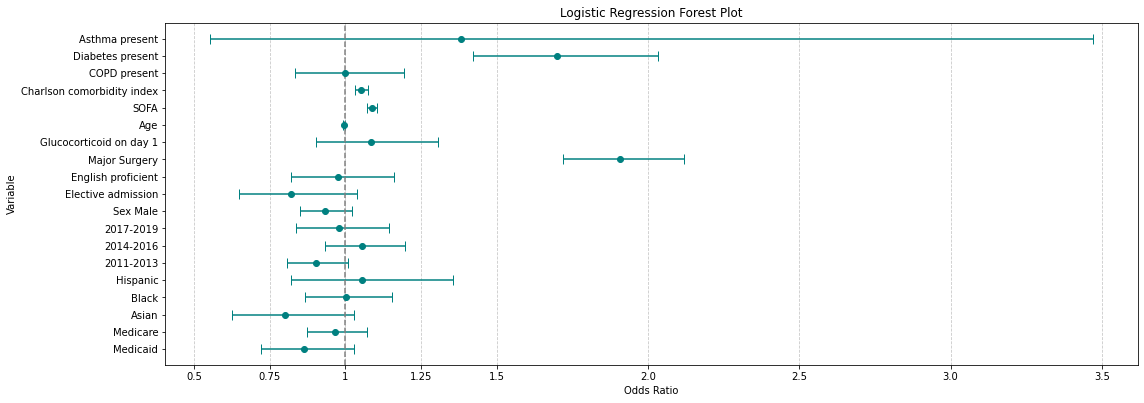

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the forest plot
plt.figure(figsize=(16, len(ratioCI) * 0.3))  # Adjust the figure size based on the number of variables
plt.errorbar(ratioCI['Odds Ratio'], ratioCI['Variable'], xerr=[ratioCI['Odds Ratio'] - ratioCI['CI_lower'], ratioCI['CI_upper'] - ratioCI['Odds Ratio']],
             fmt='o', color='teal', capsize=5)
plt.axvline(x=1.0, color='gray', linestyle='--')
plt.xlabel('Odds Ratio')
plt.ylabel('Variable')
plt.title('Logistic Regression Forest Plot')
plt.grid(axis='x', linestyle='--', alpha=0.7)

xtick_values = [0.5, 0.75, 1, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5]  # Adjust these values as needed
xtick_labels = ['0.5', '0.75', '1', '1.25', '1.5', '2.0', '2.5', '3.0', '3.5']   # Corresponding labels
plt.xticks(xtick_values, xtick_labels)

plt.tight_layout()
#plt.xlim(0.5, 2.5)

plt.savefig("../../results/4_figures/logreg_plot.png", dpi=400, facecolor='w')
plt.show()
